In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants, optimize, signal
from pyproj import Geod
import pickle
import pandas as pd
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
import os
import glob

# Load the node config dictionary this contains information about the nodes
# (receivers) position and name
node_config = np.load("node_config_fixed.npy", allow_pickle=True).item()

node_code = {}
for key in node_config.keys():
    node_code[node_config[key]['Site']] = key

In [5]:
keys_list = list(data_list.keys())

In [7]:
dt = np.timedelta64(int(data_list[keys_list[0]][0]["smplint"] * 1e9), "ns")

In [83]:
def atddict(long, lat, ref):
    '''
    Finds the Arrival Time Difference between a reference node and each other node
    based on an inputted longitude and latitude of a meteorite. Returns a dictionary
    with Site as key and ATD as value.
    '''
    
    #start atd dictionary
    atd = {}
    
    #define the speed of light in m/s (can change if we find it is different)
    c = 299792458
    
    # Loop between each node in node_config
    for node in node_config:
        geod = Geod(ellps='WGS84')
        
        # Use the geod function to find the dist to the for the node
        _, _, dist = geod.inv(node_config[node]['Position']['lon'], node_config[node]['Position']['lat'], long, lat)

        # Use the geod function to find the dist to the reference node
        _, _, ref_dist = geod.inv(node_config[ref]['Position']['lon'], node_config[ref]['Position']['lat'], long, lat)

        # Calculate the time difference
        timediff = (dist / c) - (ref_dist / c)

        # Add the ATD to the ATD dictionary in ns
        atd[node_config[node]['Site']] = np.timedelta64(int(timediff * 1e9),'ns')
        
    return atd

# Set parameter atds to be a dictionary with Watnall as the reference node
atds = atddict(-1.37,51.49,'569218Q0B001D0029')

In [84]:
atds

{'Akrotiri': numpy.timedelta64(10524587,'ns'),
 'Cabauw': numpy.timedelta64(898883,'ns'),
 'Camborne': numpy.timedelta64(479016,'ns'),
 'Gibraltar': numpy.timedelta64(5218213,'ns'),
 'Keflavik': numpy.timedelta64(5646913,'ns'),
 'Lerwick': numpy.timedelta64(2649120,'ns'),
 'Herstmonceux': numpy.timedelta64(-111458,'ns'),
 'Payerne': numpy.timedelta64(2099197,'ns'),
 'Tartu': numpy.timedelta64(5846107,'ns'),
 'Valentia': numpy.timedelta64(1524529,'ns'),
 'Watnall': numpy.timedelta64(0,'ns')}

In [119]:
datadict['Akrotiri']['time'][0] - datadict['Akrotiri']['time_inc_atd'][0]

numpy.timedelta64(-10524587,'ns')

In [8]:
# File path to data files /Volumes/WD_ITP/Bath_VLF_2023_decoded
folder_path = '/Volumes/WD_ITP/Bath_VLF_2023_decoded/2023-02-13/'
# Create list of file paths for each file in the folder
file_list = glob.glob(os.path.join(folder_path, '*.npy'))

# Create data_list dictionary
data_list = {}
# From Graeme to create a list of all the data for each of the files
for file_path in file_list:
    filename = os.path.basename(file_path)
    key = os.path.splitext(filename)[0]
    data_list[key] = np.load(file_path, allow_pickle=True).item()

datadict = {}
for key in keys_list:
    # Find which site the file refers to
    site_key = key.split('_')[0]
    
    # If there is not a section of the datadict with the site then create one
    if site_key not in datadict:
        datadict[site_key] = {
            'time': [],
            'waveform': []
        }
    # Then, add the time and waveform data to the correct part of datadict
    for i in data_list[key].keys():
        
        t = [data_list[str(key)][i]["starttime"] + dt * j for j in range(0, 1024)]
        datadict[site_key]['time'].extend(t)
        
        datadict[site_key]['waveform'].extend(list(data_list[str(key)][i]["wvfmdata"]))
        
# Add a seperate array for the time adjusted for the arrival time difference
for site in datadict:
    # Get Dunkeswell out of 'ere as there is no data for it in the node_config
    if site == 'Dunkeswell':
        pass
    else:
        datadict[site]['time_inc_atd'] = [x + atds[site] for x in datadict[site]['time']]

In [77]:
for site in datadict:
    # Get Dunkeswell out of 'ere as there is no data for it in the node_config
    if site == 'Dunkeswell':
        pass
    else:
        datadict[site]['time_inc_atd'] = [x + atds[site] for x in datadict[site]['time']]

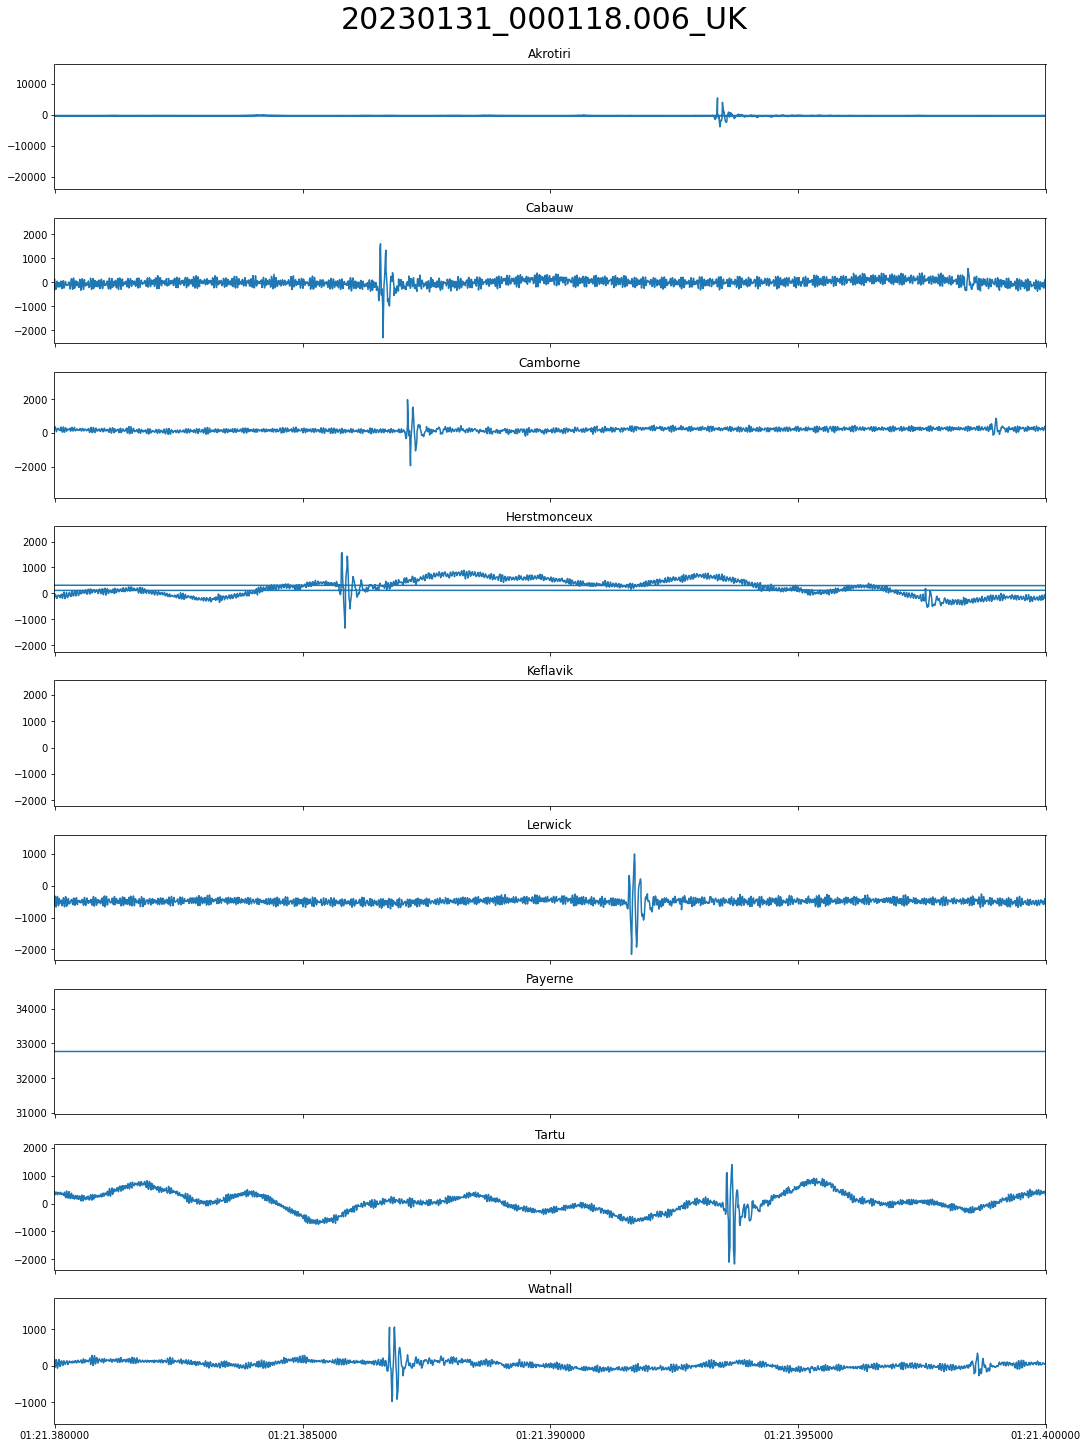

In [80]:
# Create a subplot to plot the data with title etc
# sharex=True means they are plotted on the same x axis
fig, axs = plt.subplots(len(datadict)-1,figsize=(15, 20), sharex=True, constrained_layout=True)
fig.suptitle('20230131_000118.006_UK',fontsize=30)

# Start an iterable so the data is plotted on seperate graphs
i = 0

# Loop over each site in the datadict and plot them
for site in datadict.keys():
    # Dunkeswell being Dunkeswell
    if site == 'Dunkeswell':
        pass
    else:
        axs[i].plot(datadict[site]['time_inc_atd'],datadict[site]['waveform'])
        axs[i].set_title(site)
        
        # The following line can be used to zoom in on a certain x range
        axs[i].set_xlim(np.datetime64('2023-01-31T00:01:21.38'),np.datetime64('2023-01-31T00:01:21.40'))
        
        i += 1
        
#fig.savefig('31-01-2023_Figure.png')

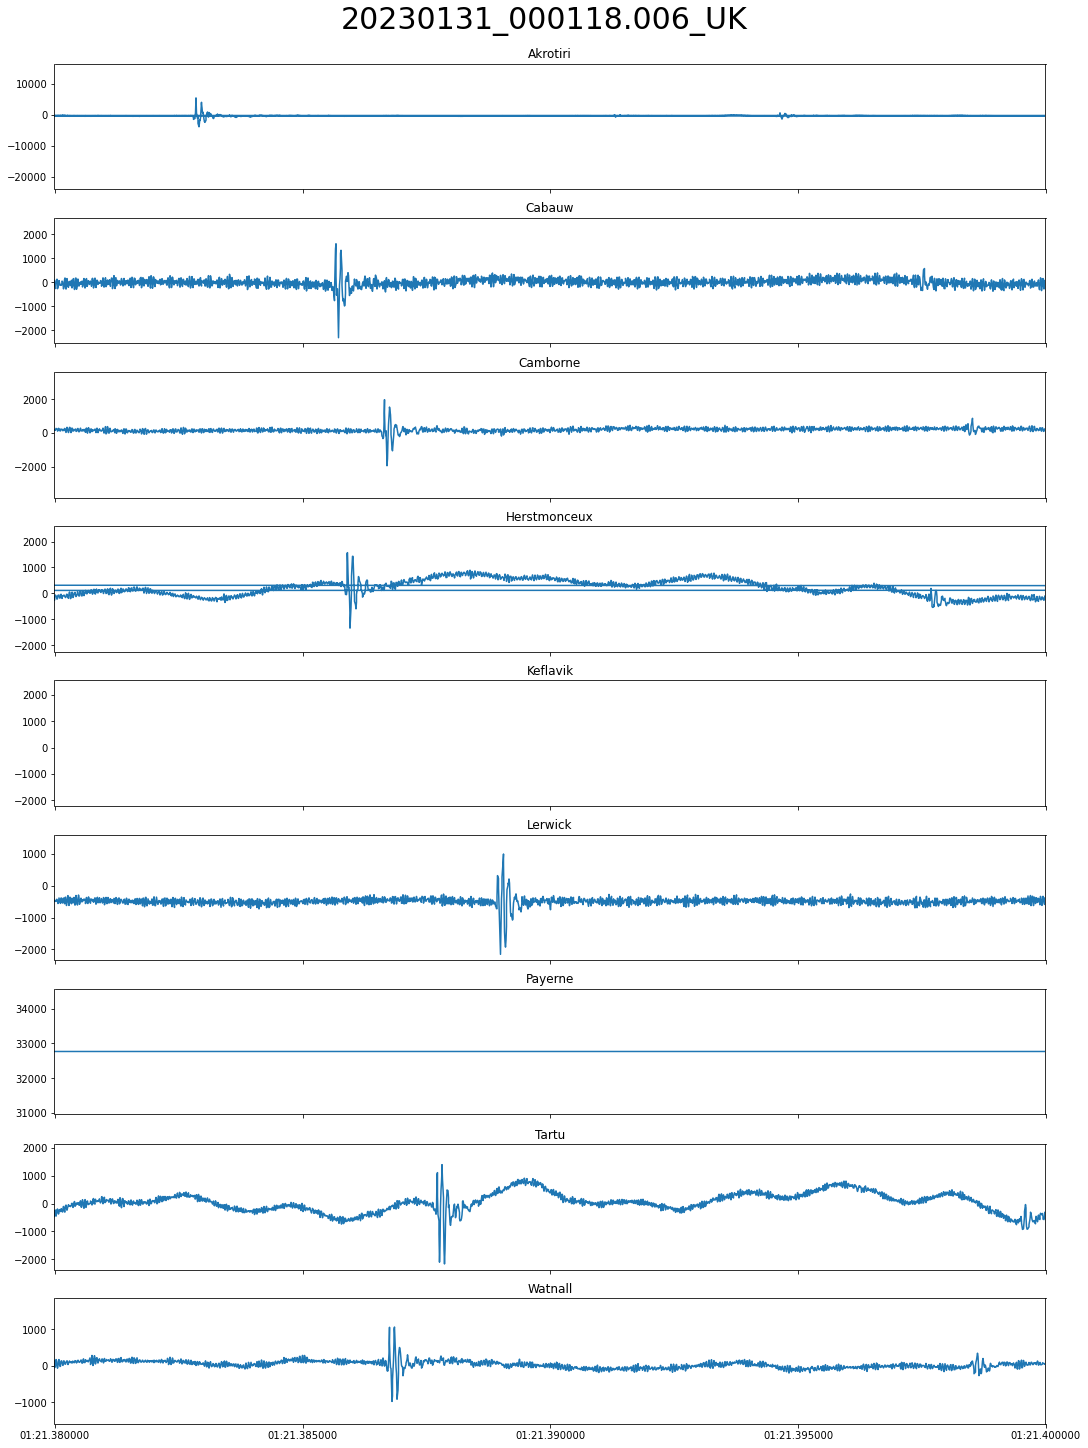

In [85]:
# Create a subplot to plot the data with title etc
# sharex=True means they are plotted on the same x axis
fig, axs = plt.subplots(len(datadict)-1,figsize=(15, 20), sharex=True, constrained_layout=True)
fig.suptitle('20230131_000118.006_UK',fontsize=30)

# Start an iterable so the data is plotted on seperate graphs
i = 0

# Loop over each site in the datadict and plot them
for site in datadict.keys():
    # Dunkeswell being Dunkeswell
    if site == 'Dunkeswell':
        pass
    else:
        axs[i].plot(datadict[site]['time'],datadict[site]['waveform'])
        axs[i].set_title(site)
        
        # The following line can be used to zoom in on a certain x range
        axs[i].set_xlim(np.datetime64('2023-01-31T00:01:21.38'),np.datetime64('2023-01-31T00:01:21.40'))
        
        i += 1
        
#fig.savefig('31-01-2023_Figure.png')

## Spike finding

In [55]:
# Finding the spikes in the waveform for a certain time range

for site in datadict:
    peaks = signal.find_peaks(datadict[site]['waveform'],1000)
    peaks_for_meteorite = []
    
    for x in peaks[0]:
        if site == 'Dunkeswell':
            pass
        elif datadict[site]['time_inc_atd'][x] <= np.datetime64('2023-01-31T00:01:21') or datadict[site]['time_inc_atd'][x] >= np.datetime64('2023-01-31T00:01:22'):
            pass
        else:
            peaks_for_meteorite.append(datadict[site]['time_inc_atd'][x])
                                
    print(site)
    print(peaks_for_meteorite)

Akrotiri
[numpy.datetime64('2023-01-31T00:01:21.392479368'), numpy.datetime64('2023-01-31T00:01:21.392579930'), numpy.datetime64('2023-01-31T00:01:21.436776760'), numpy.datetime64('2023-01-31T00:01:21.461845885')]
Cabauw
[numpy.datetime64('2023-01-31T00:01:21.385672368'), numpy.datetime64('2023-01-31T00:01:21.385782950')]
Camborne
[numpy.datetime64('2023-01-31T00:01:21.386230179'), numpy.datetime64('2023-01-31T00:01:21.386339883')]
Dunkeswell
[]
Herstmonceux
[numpy.datetime64('2023-01-31T00:01:21.384901376'), numpy.datetime64('2023-01-31T00:01:21.385001938'), numpy.datetime64('2023-01-31T00:01:21.429198757')]
Keflavik
[]
Lerwick
[numpy.datetime64('2023-01-31T00:01:21.390801352')]
Payerne
[]
Tartu
[numpy.datetime64('2023-01-31T00:01:21.392673662'), numpy.datetime64('2023-01-31T00:01:21.392774224')]
Watnall
[numpy.datetime64('2023-01-31T00:01:21.385848541'), numpy.datetime64('2023-01-31T00:01:21.385958245')]


## Noise Reduction

In [ ]:
# Used for the bandpass filter

sig = datadict['Tartu']['waveform']
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
ax1.plot(datadict['Tartu']['time'], sig)
ax1.set_title('Original signal')

sos = signal.butter(6, [200,10000], 'bp', fs=1/9.142e-6, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(datadict['Tartu']['time'], filtered)
ax2.set_title('After band-pass filter')
ax2.set_xlim(np.datetime64('2023-01-31T00:01:13'),np.datetime64('2023-01-31T00:01:23'))

## Cross-correlation

In [ ]:
for site in datadict:
    i=0
    datadict[site]['specific_waveform'] = []

    for time in datadict[site]['time']:


        if time <= np.datetime64('2023-01-31T00:01:21.38') or time >= np.datetime64('2023-01-31T00:01:21.39'):
            i += 1

        else:
            datadict[site]['specific_waveform'].append(datadict[site]['waveform'][i])
            i += 1
    
        

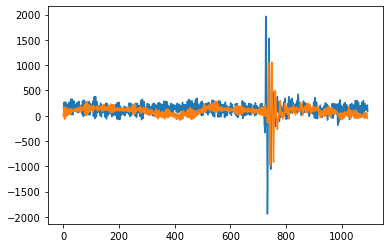

In [124]:
plt.plot(datadict['Camborne']['specific_waveform'])
plt.plot(datadict['Watnall']['specific_waveform'])

In [129]:
datadict['Camborne']['specific_waveform'].pop()

83.0

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


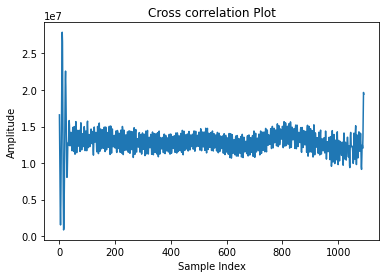

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


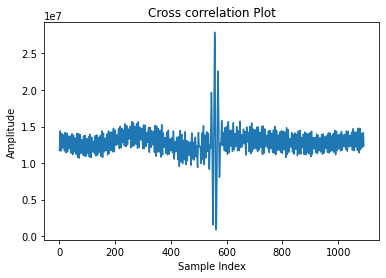

In [132]:
from scipy import fft, ifft

def correlate(a,b):
    ffta = fft.fft(a)
    fftb = fft.fft(b)
    compfftb = np.conj(fftb)
    product = compfftb*ffta
    return fft.ifft(product)

crosscorrelation = correlate(datadict['Watnall']['specific_waveform'], datadict['Camborne']['specific_waveform'])
rolled_cc = np.roll(crosscorrelation, shift=547)

plt.plot(crosscorrelation)
plt.title('Cross correlation Plot')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

plt.plot(rolled_cc)
plt.title('Cross correlation Plot')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

In [134]:
(np.argmax(rolled_cc) - 547) * 9.142e-6

9.142e-05

In [ ]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants, optimize
from pyproj import Geod
import pickle
import pandas as pd
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

# Load the node_config dictionary that contains information about the nodes
# (receivers) position and name
node_config = np.load("node_config_fixed.npy", allow_pickle=True).item()

# Load in waveforms
waveforms = np.load("exported_waveforms.npy", allow_pickle=True)

# For each waveform the following variables are available
# envelope      : The magnitude of the waveform envelope with time
# FT            : The Fast fourier transform of samples
# FT_recon      : The Fast fourire transform of the reconstructed time series
# node_unique_id: A 17 character unique identifier for a node
# peak_index    : The index in the raw data stream that the peak in envelope resides
# prod_time     : The time the waveform was extracted
# raw_data      : The raw time series the waveform was extracted from that has been high pass filtered at 1kHz
# recon_data    : The reconstructed complex time series the waveform was extracted from same as reconstructed samples
# samples       : The real part of extracted waveform
# site_name     : Name of site waveform was recorded at
# t1            : The sum of samples ^ 2
# tdv_penalty   : A time difference variance penalty 
# timestamp     : np.datetime64 object which contains the timestamp at index 256 of samples, envelope, raw_data and recon_data

# The sampling resolution of LEELA is 9.142 us


# Create a dictionary node_code with the key being the site and the value being the node code
node_code = {}
for key in node_config.keys():
    node_code[node_config[key]['Site']] = key


def TATD(waveforms, guess):
    '''
    Finds the Theoretical Arrival Time Difference for each node by calculating distance from a reference node 
    to each node using pyproj's Geod function. Adds these TATDs to one list.
    '''
    
    # Define the Geod function
    geod = Geod(ellps='WGS84')
    
    # Calculate the distance from the reference node to the event
    _, _, dist_GA = geod.inv(waveforms[0]['lon'], waveforms[0]['lat'], guess[0], guess[1])

    # Open list of distances from non-reference nodes to event
    dist_GBs = []
    # Append the distances from non-reference nodes to event to dist_GBs
    for i in range(1, 7):
        _, _, dist_GB = geod.inv(waveforms[i]['lon'], waveforms[i]['lat'], guess[0], guess[1])
        dist_GBs.append(dist_GB)
    
    # Create list of TATDs
    TATDs = []

    # Define the phase velocity
    vp = 2.99792458e8 * 1.00425
    
    # Calculate the TATD for each node and append to TATDs
    for i in range(0, 6):
        TATD = abs(dist_GBs[i] / vp) - abs(dist_GA / vp)
        TATDs.append(TATD)
    return TATDs


def RES(guess, waveforms, OATDs):
    '''
    Function to be minimised. Calculates the residual of how close the guess is 
    to the actual lightning strike location.
    '''
    # Use TATD function to find TATDs
    TATDs = TATD(waveforms, guess)
    # Find variance
    vari = np.var(OATDs)
    # Determine N from amount of values in OATDs
    N = len(OATDs)

    # Calculate the value of RES
    sumATD = 0
    for i in range(0, 5):
        sumATD = sumATD + (TATDs[i] - OATDs[i]) ** 2 / vari
    RES = np.sqrt((1 / (N - 2) * sumATD))
    
    # Print RES value
    print(RES)
    
    # Return RES value for each minimisation
    return RES


#Define the OATDs list
OATDs = []

# Add the latitude and longitude to the waveforms dictionary from node_config.
for i in range(0,7):
    waveforms[i]['lat'] = node_config[node_code[waveforms[i]['site_name']]]['Position']['lat']
    waveforms[i]['lon'] = node_config[node_code[waveforms[i]['site_name']]]['Position']['lon']

# Find the observed time difference by taking the value of the difference between the two timestamps.
for i in range(1, 7):
    OATDs.append((waveforms[i]['timestamp'] - waveforms[0]['timestamp']).astype(float)/1e9)
    
# Print the OATDs
for i in range(0, 6):
    print(OATDs[i])


# Initalise guess in London (Long=-0.118092 , Lat=51.509865)
guess = np.array([-0.118092, 51.509865])

# Call the minimise function from scipy, minimising the RES function until it is sufficiently small.
# (Can change the method of minimisation)
result = minimize(RES, guess, args=(waveforms, OATDs), method='Nelder-Mead')

# Print the result
print(result)